In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
Seq_length = 5
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
class LSTM_use_V(nn.Module):
    def __init__(self):
        super().__init__()

        self.LSTM_layer = nn.LSTM(input_size=10,
                                hidden_size = 30,
                                num_layers = 2,
                                batch_first=True,
                                dropout=DROP_OUT_R)
        
        self.FC_layer = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(DROP_OUT_R),
            nn.Linear(30,1)
        )
    
    def forward(self, input_x):
        lstm_y,_ = self.LSTM_layer(input_x)
        lstm_y = lstm_y[:,-1,:]

        y = self.FC_layer(lstm_y)

        return y

LSTM = LSTM_use_V().to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(LSTM)) #사용

12511


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(LSTM.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        LSTM.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = LSTM(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### LSTM 데이터 준비 (Seq_length = 5(i ~ i+5사이클로 i+6사이클 예측할 예정) , input_feature = 10(한 cycle당 10개 데이터 사용))

In [10]:
# 10개의 Voltage_measured로 다음 번째의 Capacity를 예측
# Voltage_measure 10개씩 묶어 준비 n개 준비
# Capacity도 n개 준비

def prepareXY_forLSTM(X_ndArray, y_ndArray, Seq_length):
   X_ndArray = X_ndArray.reshape(-1,10)
   X_data = []
   for idx in range(0, X_ndArray.shape[0]):
      if (idx+1)-Seq_length < 0:
         tmp = np.zeros((Seq_length-(idx+1), 10))
         tmp = np.concatenate((tmp, X_ndArray[0:idx+1]), axis=0)
         X_data.append(tmp)
      else:
         X_data.append(X_ndArray[(idx+1)-Seq_length:idx+1])
      
   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("./FNN1_params.pt")
FNN1_forB0005.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [11]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"./Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
        y_df = pd.read_csv(f"./Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled, Seq_length)
        X_data = torch.from_numpy(X_data).type(torch.float)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)
        
        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [12]:
all_data_train_wrapper()

,cycle,voltage_measured,time
0,2,3.320249,5.500
76,2,3.772765,234.078
152,2,3.869867,511.156
228,2,3.928052,875.062
304,2,3.968767,1364.266
...,...,...,...
375596,169,4.198806,3460.406
375852,169,4.199172,4206.797
376108,169,4.199734,4952.406
376364,169,4.199159,5697.531


epoch :  0 train loss:  0.16927048051729798
epoch :  10 train loss:  0.10606070142239332
epoch :  20 train loss:  0.09749122243374586
epoch :  30 train loss:  0.0909159192815423
epoch :  40 train loss:  0.08301099389791489
epoch :  50 train loss:  0.0631195418536663
epoch :  60 train loss:  0.030610117129981518
epoch :  70 train loss:  0.02090284216683358
epoch :  80 train loss:  0.019687274238094687
epoch :  90 train loss:  0.019046462955884635
epoch :  100 train loss:  0.01778203423600644
epoch :  110 train loss:  0.017977322975639254
epoch :  120 train loss:  0.017487585893832147
epoch :  130 train loss:  0.012738324119709432
epoch :  140 train loss:  0.014905832766089588
epoch :  150 train loss:  0.015362363890744746
epoch :  160 train loss:  0.016740077058784664
epoch :  170 train loss:  0.012371158576570451
epoch :  180 train loss:  0.013483066926710308
epoch :  190 train loss:  0.012893105100374669
epoch :  200 train loss:  0.015309348935261369
epoch :  210 train loss:  0.013666

,cycle,voltage_measured,time
0,2,3.270404,5.500
76,2,3.785553,234.078
152,2,3.881019,511.156
228,2,3.937696,875.062
304,2,3.978918,1364.266
...,...,...,...
375596,169,4.211561,3460.406
375852,169,4.212398,4206.797
376108,169,4.213197,4952.406
376364,169,4.211974,5697.531


epoch :  0 train loss:  0.03919392614625394
epoch :  10 train loss:  0.016481902915984392
epoch :  20 train loss:  0.012402091291733086
epoch :  30 train loss:  0.020024147001095116
epoch :  40 train loss:  0.013372146873734891
epoch :  50 train loss:  0.014780629891902208
epoch :  60 train loss:  0.01347606664057821
epoch :  70 train loss:  0.012620946508832276
epoch :  80 train loss:  0.012554501532576978
epoch :  90 train loss:  0.0196691055316478
epoch :  100 train loss:  0.012247065315023065
epoch :  110 train loss:  0.012644472531974316
epoch :  120 train loss:  0.014747873181477189
epoch :  130 train loss:  0.011985231307335198
epoch :  140 train loss:  0.008989795693196356
epoch :  150 train loss:  0.012601050082594156
epoch :  160 train loss:  0.014649637043476105
epoch :  170 train loss:  0.013845516368746758
epoch :  180 train loss:  0.010562129318714142
epoch :  190 train loss:  0.01062267308589071
epoch :  200 train loss:  0.011577955912798643
epoch :  210 train loss:  0.0

,cycle,voltage_measured,time
0,2,3.479525,5.219
257,2,3.938450,653.547
514,2,3.997673,1303.219
771,2,4.049742,1952.907
1028,2,4.124331,2602.360
...,...,...,...
190602,134,4.198443,3527.000
190702,134,4.198810,4252.766
190802,134,4.200036,4977.859
190902,134,4.199606,5706.000


epoch :  0 train loss:  0.08955765205125014
epoch :  10 train loss:  0.0402338250229756
epoch :  20 train loss:  0.032041587556401886
epoch :  30 train loss:  0.028777186448375385
epoch :  40 train loss:  0.031217959399024647
epoch :  50 train loss:  0.028494589651624363
epoch :  60 train loss:  0.02685090775291125
epoch :  70 train loss:  0.022258838638663292
epoch :  80 train loss:  0.021584345027804375
epoch :  90 train loss:  0.024251519391934078
epoch :  100 train loss:  0.020626443127791088
epoch :  110 train loss:  0.02019636829694112
epoch :  120 train loss:  0.01780540496110916
epoch :  130 train loss:  0.021173462892572086
epoch :  140 train loss:  0.019199052825570107
epoch :  150 train loss:  0.01741208601742983
epoch :  160 train loss:  0.016887907249232132
epoch :  170 train loss:  0.01358768887196978
epoch :  180 train loss:  0.016240738642712433
epoch :  190 train loss:  0.013773544070621332
epoch :  200 train loss:  0.011704737630983194
epoch :  210 train loss:  0.0110

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

LSTM_params = LSTM.state_dict()
torch.save(LSTM_params, "../BEST_MODEL/LSTM_params.pt")

### B0005 예측

In [13]:
x_df = pd.read_csv(f"./Data/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
y_df = pd.read_csv(f"./Data/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled,Seq_length)
X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

LSTM.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = LSTM(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,time
0,2,3.434644,5.500
76,2,3.814079,234.078
152,2,3.881686,511.156
228,2,3.937241,875.062
304,2,3.979605,1364.266
...,...,...,...
375596,169,4.205285,3460.406
375852,169,4.205106,4206.797
376108,169,4.204985,4952.406
376364,169,4.206357,5697.531


In [14]:
predicts_df

,0
0,1.816469
1,1.801074
2,1.813758
3,1.782017
4,1.789508
...,...
162,1.293874
163,1.343697
164,1.331539
165,1.325017


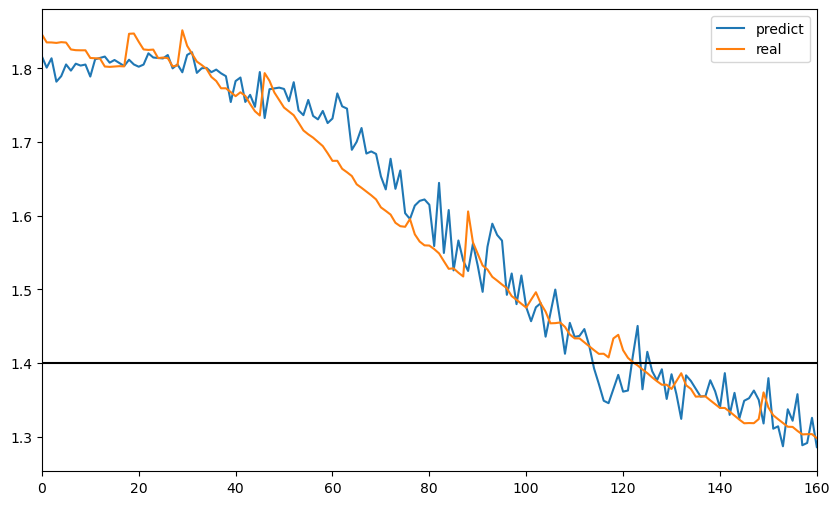

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("./PREDICT/LSTM.csv", index = False)